In [3]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

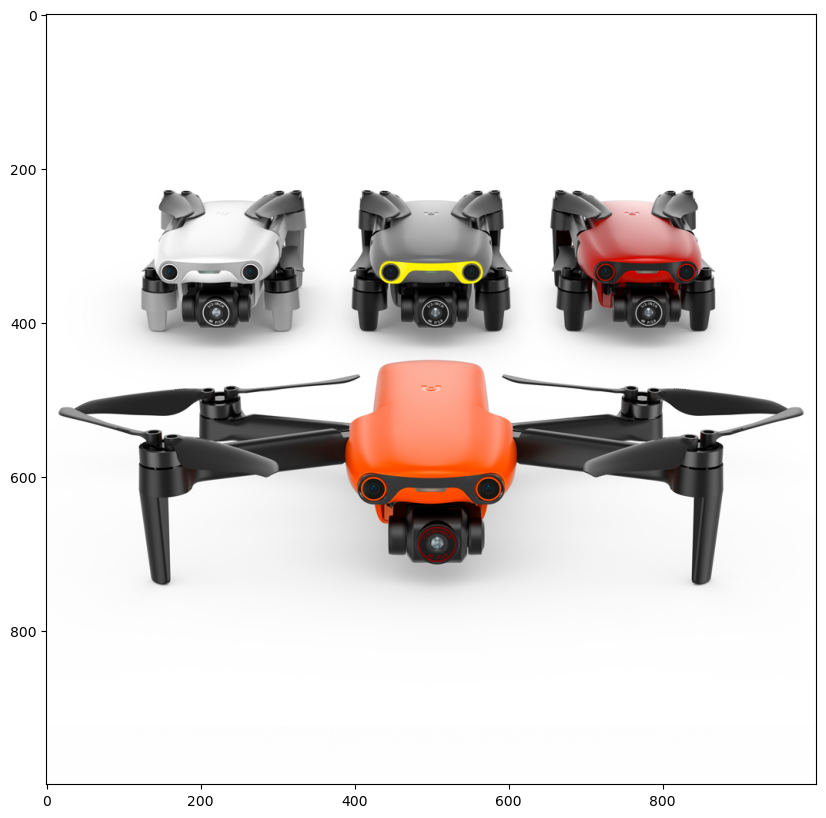

In [5]:
# Load image
img = cv2.imread('data/drns.jpg')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

In [7]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

In [13]:
# Cast the image to float
img = img.astype(np.float32)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c]
        
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        dist = np.linalg.norm(colors - pixel, axis = 1)
        closest_colour = np.argmin(dist)
        new_pixel =  colors[closest_colour]
        
        # Apply quantization
        quantized[r, c, :] = new_pixel

(<Axes: >, <matplotlib.image.AxesImage at 0x19b4d3ed100>)

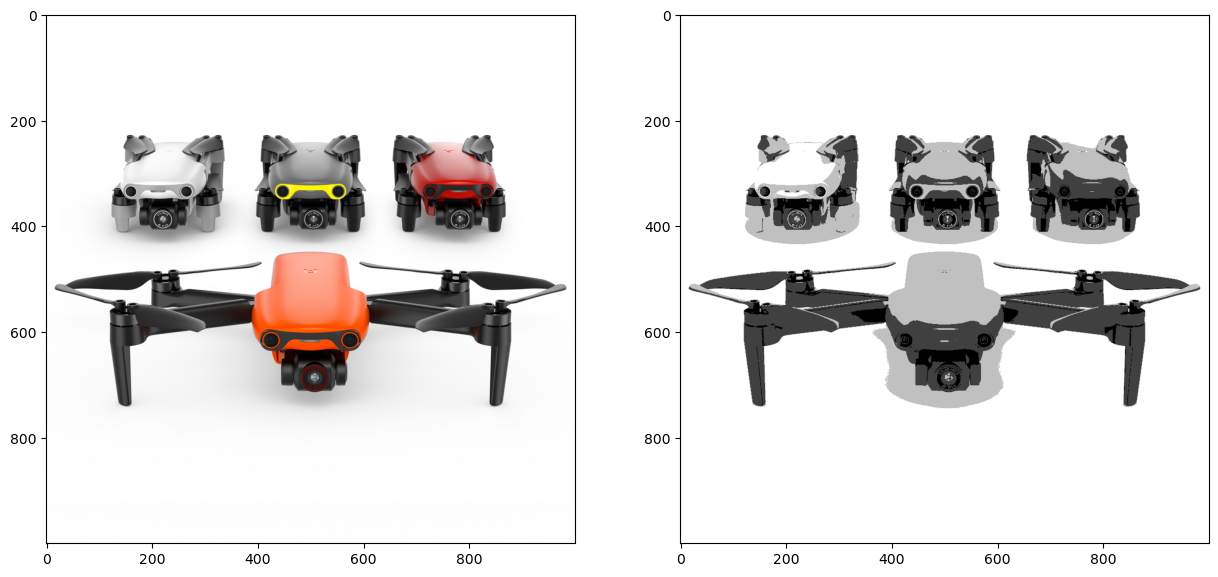

In [15]:
# Show quantized image (don't forget to cast back to uint8)
img = img.astype(np.uint8)
quantized = quantized.astype(np.uint8)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(quantized)

In [17]:
# Compute average quantization error
quant_err = img.astype(np.float32) - quantized.astype(np.float32)
mse = np.mean(quant_err**2)
psnr = 10 * np.log10((255**2)/mse)
print('PSNR', psnr, 'dB')

PSNR 21.907869816152512 dB


In [19]:
# Make a temporal copy of the original image, we will need it for error diffusion
img_tmp = np.copy(img)
img_tmp = img_tmp.astype(np.float32)
dithering = np.zeros_like(img)
rows, cols, channels = img_tmp.shape

colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        dist = np.linalg.norm(colors - pixel, axis = 1)
        closest_colour = np.argmin(dist)
        new_pixel =  colors[closest_colour]        
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        img_tmp[r, c + 1] += quant_error * 7 / 16 
        img_tmp[r + 1, c - 1] += quant_error * 3 / 16
        img_tmp[r + 1, c] += quant_error * 5 / 16
        img_tmp[r + 1, c - 1] += quant_error * 1 / 16
        
        # Apply dithering
        dithering[r, c, :] = new_pixel

(<Axes: >, <matplotlib.image.AxesImage at 0x19b4d763200>)

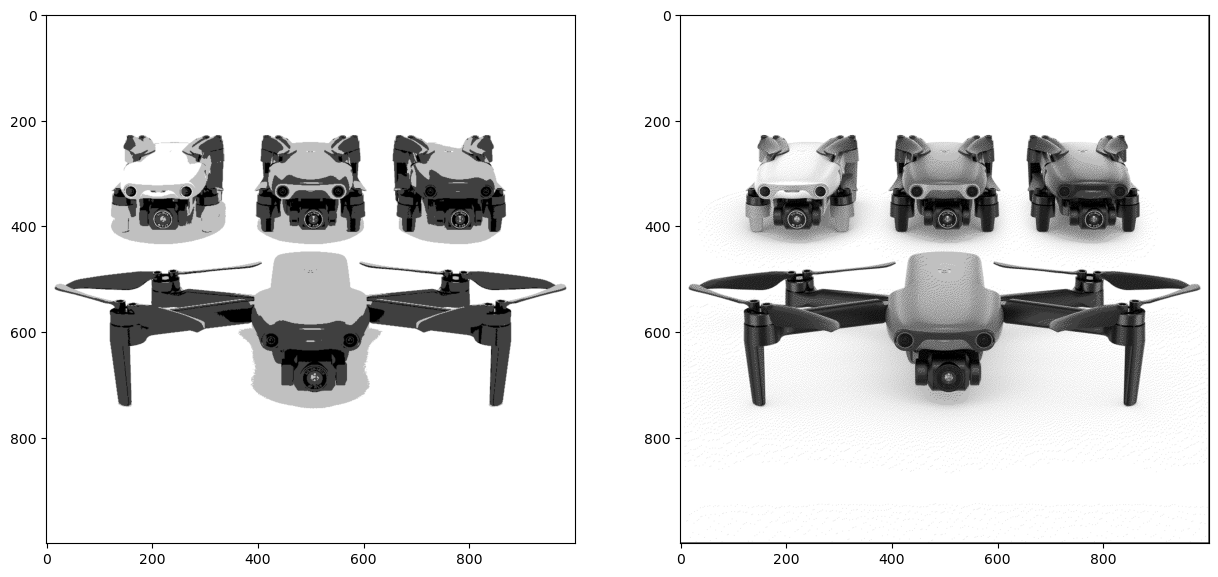

In [21]:
# Show quantized image (don't forget to cast back to uint8)
dithering = dithering.astype(np.uint8)
plt.subplot(121), plt.imshow(quantized)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [23]:
# Compute average quantization error for dithered image
avg_dith_error = img.astype(np.float32) - dithering.astype(np.float32)
mse = np.mean(avg_dith_error**2)
psnr = 10 * np.log10((255**2)/mse)
print('PSNR', psnr, 'dB')

PSNR 18.523720993516626 dB


In [ ]:
# -------------------------------------------------------BONUS_POINTS-------------------------------------------------------

In [33]:
from sklearn.cluster import KMeans
 # Load image
img1 = cv2.imread('data/col_dr.jpg')
kmeans = KMeans(n_clusters=16).fit(np.reshape(img, (-1, 1)))
colors = kmeans.cluster_centers_

In [35]:
img_tmp = np.copy(img)
img_tmp = img_tmp.astype(np.float32)
dithering = np.zeros_like(img)
rows, cols, channels = img_tmp.shape

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the original pixel value
        pixel = img_tmp[r, c]
        # Find the closest colour from the pallette (using absolute value/Euclidean distance)
        # Note: You may need more than one line of code here
        dist = np.linalg.norm(colors - pixel, axis = 1)
        closest_colour = np.argmin(dist)
        new_pixel =  colors[closest_colour]        
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error accroding to the FS diffusion matrix
        # Note: You may need more than one line of code here
        img_tmp[r, c + 1] += quant_error * 7 / 16 
        img_tmp[r + 1, c - 1] += quant_error * 3 / 16
        img_tmp[r + 1, c] += quant_error * 5 / 16
        img_tmp[r + 1, c - 1] += quant_error * 1 / 16
        
        # Apply dithering
        dithering[r, c, :] = new_pixel

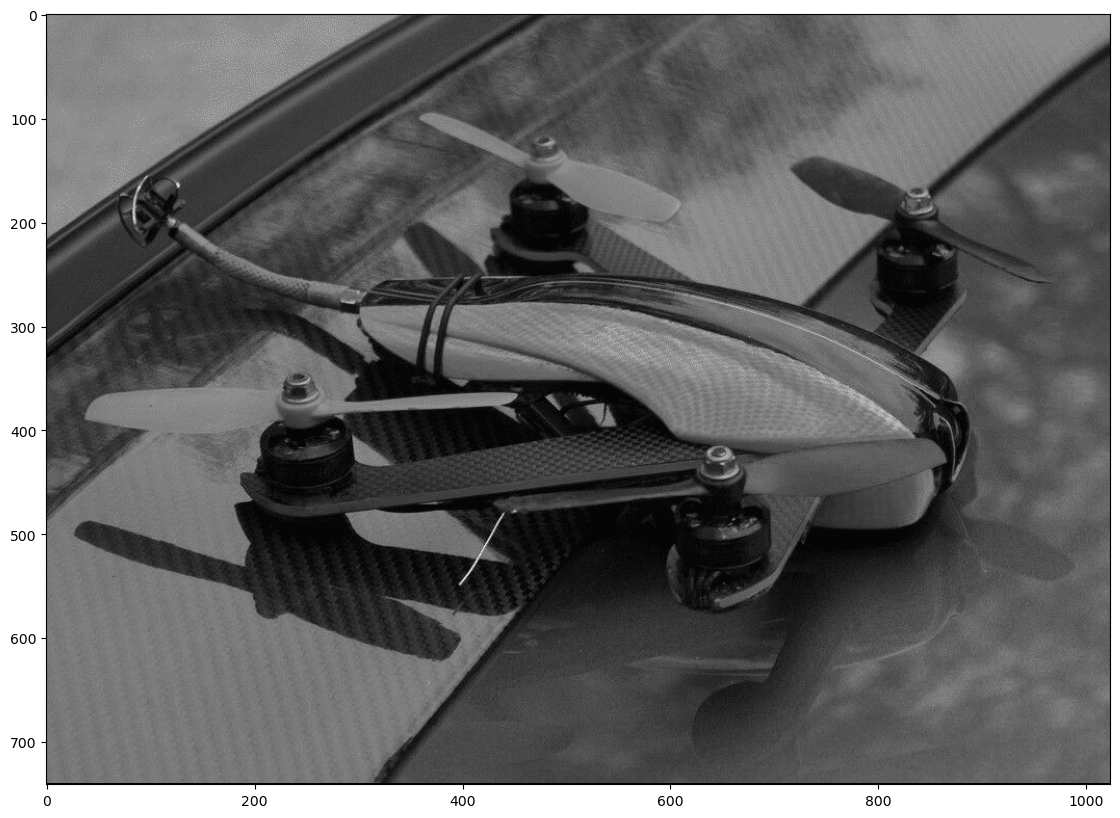

In [37]:
dithering = dithering.astype(np.uint8)
plt.imshow(dithering)   # dithering

In [39]:
# Compute average quantization error for dithered image
avg_dith_error = img.astype(np.float32) - dithering.astype(np.float32)
mse = np.mean(avg_dith_error**2)
psnr = 10 * np.log10((255**2)/mse)
print('PSNR', psnr, 'dB')

PSNR 19.034281066735257 dB


In [ ]:
# How does the result look like to you?   ---   High contrast, dithering allowing for gradients to appear smoother, with black or white pixels.
# What happens if we use 32 colours?      ---   Allows you to use a wider palette, a more detailed image, but with some limitations
# And what happens if we use 256 colours? ---   More visually pleasing result, with more accurate representation
                                                                                                # of the original image, thanks to the larger palette.